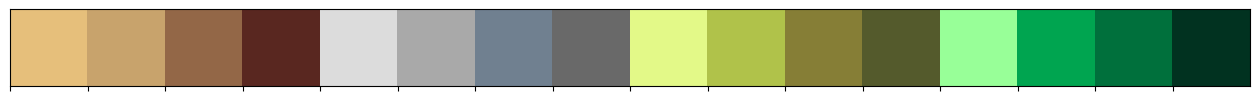

In [1]:
import pandas as pd  
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

colors = [
    "#e6bf7b", "#c8a36c", "#936747", "#592720", "#dcdcdc", "#a9a9a9",
    "#708090", "#696969", "#e3f988", "#b0c24a", "#867e36", "#545a2c",
    "#98ff98", "#00a550", "#00703c", "#013220"
]
sns.palplot(sns.color_palette(colors))

Loading data...

In [2]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

# Load and Clean Data
df = pd.read_csv('fdia_data/data1.csv')

# Change column "marker" to numerical value
df['marker'] = pd.Categorical(df['marker']).codes

# Data cleaning
df = df.dropna()
df = df.replace([float('inf'), float('-inf')], float('nan'))
df = df.dropna()

# Split the data
X = df[df.columns.difference(['marker'])].values
Y = df['marker'].values

# Standardize the features
scaler = MinMaxScaler(feature_range=(-1, 1))
# X_transform = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test_transform = scaler.transform(X_test)
# print(f"X_test_transform: {X_test_transform}")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test_transform, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
# # save data for further verification
# import numpy as np

X_test_np = X_test.numpy()
X_test_np_transform = X_test_transform
Y_test_np = Y_test.numpy()
np.savez(f'np_data/test_data_01_original.npz', X=X_test_np, y=Y_test_np)
np.savez(f'np_data/test_data_01.npz', X=X_test_np_transform, y=Y_test_np)

define the model...

In [4]:
import torch
import torch.nn as nn
# Define FFNN Model
class FFNN(nn.Module):
    def __init__(self, input_size, output_size, hiddens=[50, 100, 50]):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hiddens[0])
        self.fc2 = nn.Linear(hiddens[0], hiddens[1])
        self.fc3 = nn.Linear(hiddens[1], hiddens[2])
        self.fc4 = nn.Linear(hiddens[2], output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

import torch.onnx

# Function to save the model as ONNX format
def save_model_onnx(model, input_size, onnx_file_path):
    # Set the model to evaluation mode
    model.eval()
    
    # Create a dummy input tensor with the correct input size (batch_size, input_size)
    # The batch size can be arbitrary, here batch size is set to 1
    x = torch.randn(1, input_size, requires_grad=False)
    
    # Export the model
    torch_out = torch.onnx.export(model,         # Model being run
                                   x,             # Model input (or a tuple for multiple inputs)
                                   onnx_file_path, # Where to save the model
                                   export_params=True,  # Store the trained parameter weights inside the model file
                                   opset_version=9)    # The ONNX version to export the model to)
    print('Model has been saved in ONNX format at {}'.format(onnx_file_path))


In [9]:
import torch.optim as optim
from tqdm import tqdm

from trades import trades_loss

def adversarial_training(model, optimizer, criterion, train_loader, num_epochs, device="cuda", args=None):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            # calculate robust loss - TRADES loss
            loss = trades_loss(model=model,
                            x_natural=data,
                            y=target,
                            optimizer=optimizer,
                            step_size=args['step_size'],
                            epsilon=args['epsilon'],
                            perturb_steps=args['num_steps'],
                            beta=args['beta'], 
                            distance='l_inf',
                            criterion=criterion)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            loss.backward()
            optimizer.step()
        if epoch % 20 == 0:
            print('Epoch [{}/{}], \t Loss: {:.4f}, \t Train Acc: {:.4f}'.format(epoch+1, num_epochs, loss.item(), 100.0*correct/total))
    model.eval()

In [12]:

hiddens = [100, 200, 100] #lr 0.0002
# hiddens = [200, 400, 200]
model = FFNN(input_size=X.shape[1], output_size=2, hiddens=hiddens)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300
args = {
    'step_size': 0.01,
    'epsilon': 0.05,
    'num_steps': 2,
    'beta': 2
}
model.to("cuda")
adversarial_training(model, optimizer, criterion, train_loader, num_epochs, 
                     device="cuda", args=args)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<02:04,  2.40it/s]

Epoch [1/300], 	 Loss: 0.5516, 	 Train Acc: 77.6665


  7%|▋         | 21/300 [00:07<01:41,  2.75it/s]

Epoch [21/300], 	 Loss: 0.3311, 	 Train Acc: 82.4851


 14%|█▎        | 41/300 [00:15<01:35,  2.72it/s]

Epoch [41/300], 	 Loss: 0.2995, 	 Train Acc: 88.5219


 20%|██        | 61/300 [00:22<01:27,  2.73it/s]

Epoch [61/300], 	 Loss: 0.2473, 	 Train Acc: 90.7688


 27%|██▋       | 81/300 [00:29<01:16,  2.85it/s]

Epoch [81/300], 	 Loss: 0.1438, 	 Train Acc: 91.2832


 34%|███▎      | 101/300 [00:36<01:09,  2.86it/s]

Epoch [101/300], 	 Loss: 0.2246, 	 Train Acc: 93.0157


 40%|████      | 121/300 [00:43<01:02,  2.85it/s]

Epoch [121/300], 	 Loss: 0.1991, 	 Train Acc: 93.2052


 47%|████▋     | 141/300 [00:50<00:55,  2.86it/s]

Epoch [141/300], 	 Loss: 0.1501, 	 Train Acc: 93.6925


 54%|█████▎    | 161/300 [00:57<00:50,  2.73it/s]

Epoch [161/300], 	 Loss: 0.1779, 	 Train Acc: 93.9903


 60%|██████    | 181/300 [01:04<00:43,  2.73it/s]

Epoch [181/300], 	 Loss: 0.1994, 	 Train Acc: 93.8549


 67%|██████▋   | 201/300 [01:12<00:35,  2.82it/s]

Epoch [201/300], 	 Loss: 0.2435, 	 Train Acc: 94.1527


 74%|███████▎  | 221/300 [01:19<00:27,  2.86it/s]

Epoch [221/300], 	 Loss: 0.1616, 	 Train Acc: 94.5046


 80%|████████  | 241/300 [01:26<00:20,  2.87it/s]

Epoch [241/300], 	 Loss: 0.1902, 	 Train Acc: 94.7482


 87%|████████▋ | 261/300 [01:33<00:13,  2.86it/s]

Epoch [261/300], 	 Loss: 0.1454, 	 Train Acc: 95.1814


 94%|█████████▎| 281/300 [01:40<00:06,  2.74it/s]

Epoch [281/300], 	 Loss: 0.1892, 	 Train Acc: 94.7212


100%|██████████| 300/300 [01:47<00:00,  2.79it/s]


In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Accuracy of the model on the test dataset: {} %'.format(accuracy))

model_path = f'onnx_models/fdia_model_ffnn_pytorch_{hiddens[0]}_{hiddens[1]}_{hiddens[2]}'
# Save the model checkpoint
torch.save(model.state_dict(), f'{model_path}_torch.pth')

# Save the model
input_size = X.shape[1]
onnx_file_path = f'{model_path}.onnx'
model.to("cpu")
save_model_onnx(model, input_size, onnx_file_path)

print("Model saved.")

Test Accuracy of the model on the test dataset: 0.9285714285714286 %
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been saved in ONNX format at onnx_models/fdia_model_ffnn_pytorch_100_200_100.onnx
Model saved.
